In [1]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

In [2]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
# Load dataset
data_dir = '/content/drive/MyDrive/FaceOcclusion'
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Splitting dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2)

dataloaders = {'train': train_loader, 'val': val_loader}


# Calculate dataset sizes
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Model
model_ft = models.mobilenet_v3_large(pretrained=True)
num_ftrs = model_ft.classifier[3].in_features
model_ft.classifier[3] = nn.Linear(num_ftrs, len(dataset.classes))  # Adjusting the classifier

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 81.7MB/s]


In [6]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Wrap dataloaders[phase] with tqdm for a progress bar
            progress_bar = tqdm(dataloaders[phase], desc=f'{phase} Phase', leave=False)

            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update progress bar with the current loss
                progress_bar.set_postfix(loss=loss.item(), acc=torch.sum(preds == labels.data).item()/inputs.size(0))

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


train Phase:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3665 Acc: 0.8410


val Loss: 0.5572 Acc: 0.7523
Epoch 1/24
----------


train Phase:  25%|██▍       | 27/109 [00:01<00:05, 14.52it/s, acc=1, loss=0.0255]  /usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1878 Acc: 0.9309


val Loss: 0.3588 Acc: 0.8165
Epoch 2/24
----------


train Phase:   5%|▍         | 5/109 [00:00<00:07, 13.08it/s, acc=1, loss=0.199]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  49%|████▊     | 53/109 [00:03<00:03, 17.52it/s, acc=1, loss=0.0151]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1453 Acc: 0.9401


val Loss: 0.2922 Acc: 0.8807
Epoch 3/24
----------


train Phase:  72%|███████▏  | 79/109 [00:06<00:01, 19.08it/s, acc=1, loss=0.179]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  94%|█████████▍| 103/109 [00:07<00:00, 18.29it/s, acc=0.75, loss=0.726]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1583 Acc: 0.9447


val Loss: 0.3097 Acc: 0.8624
Epoch 4/24
----------


train Phase:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0807 Acc: 0.9770


val Loss: 0.2198 Acc: 0.9083
Epoch 5/24
----------


train Phase:  10%|█         | 11/109 [00:01<00:10,  9.74it/s, acc=0.75, loss=0.252]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  41%|████▏     | 45/109 [00:03<00:03, 17.10it/s, acc=1, loss=0.0542]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1069 Acc: 0.9654


val Loss: 0.3563 Acc: 0.8716
Epoch 6/24
----------


train Phase:  24%|██▍       | 26/109 [00:01<00:05, 15.04it/s, acc=1, loss=0.0731]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  75%|███████▌  | 82/109 [00:06<00:02, 11.59it/s, acc=1, loss=0.00758]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0555 Acc: 0.9839


val Loss: 0.2917 Acc: 0.8899
Epoch 7/24
----------


train Phase:   3%|▎         | 3/109 [00:00<00:10,  9.69it/s, acc=1, loss=0.0822]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0386 Acc: 0.9931


val Loss: 0.2665 Acc: 0.8716
Epoch 8/24
----------


train Phase:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  60%|█████▉    | 65/109 [00:05<00:02, 16.05it/s, acc=1, loss=0.0157]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0743 Acc: 0.9770


val Loss: 0.2243 Acc: 0.8991
Epoch 9/24
----------


train Phase:   3%|▎         | 3/109 [00:00<00:09, 10.90it/s, acc=1, loss=0.0213] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  28%|██▊       | 30/109 [00:02<00:07, 11.00it/s, acc=1, loss=0.00112]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0560 Acc: 0.9862


val Loss: 0.2251 Acc: 0.8991
Epoch 10/24
----------


train Phase:  15%|█▍        | 16/109 [00:01<00:05, 16.07it/s, acc=0.75, loss=0.394]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  64%|██████▍   | 70/109 [00:04<00:02, 17.19it/s, acc=1, loss=0.102]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0553 Acc: 0.9862


val Loss: 0.2546 Acc: 0.8716
Epoch 11/24
----------


train Phase:   3%|▎         | 3/109 [00:00<00:11,  9.15it/s, acc=1, loss=0.0444]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  82%|████████▏ | 89/109 [00:06<00:01, 10.90it/s, acc=1, loss=0.00304]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0309 Acc: 0.9954


val Loss: 0.2356 Acc: 0.8899
Epoch 12/24
----------


train Phase:  44%|████▍     | 48/109 [00:02<00:03, 16.45it/s, acc=1, loss=0.031]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  62%|██████▏   | 68/109 [00:04<00:02, 18.25it/s, acc=1, loss=0.0172]  /usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0417 Acc: 0.9862


val Loss: 0.2367 Acc: 0.8899
Epoch 13/24
----------


train Phase:   5%|▍         | 5/109 [00:00<00:11,  9.38it/s, acc=1, loss=0.0319]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0757 Acc: 0.9793


val Loss: 0.2366 Acc: 0.8899
Epoch 14/24
----------


train Phase:  90%|████████▉ | 98/109 [00:06<00:01, 10.41it/s, acc=1, loss=0.0354]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  95%|█████████▌| 104/109 [00:07<00:00, 13.60it/s, acc=1, loss=0.0233] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0593 Acc: 0.9885


val Loss: 0.2336 Acc: 0.8899
Epoch 15/24
----------


train Phase:  27%|██▋       | 29/109 [00:01<00:04, 18.59it/s, acc=1, loss=0.0172]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  47%|████▋     | 51/109 [00:02<00:02, 20.13it/s, acc=1, loss=0.102]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0390 Acc: 0.9931


val Loss: 0.2422 Acc: 0.8899
Epoch 16/24
----------


train Phase:   8%|▊         | 9/109 [00:01<00:09, 10.38it/s, acc=1, loss=0.00223]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  52%|█████▏    | 57/109 [00:05<00:05,  8.68it/s, acc=1, loss=0.00759]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0513 Acc: 0.9862


val Loss: 0.2422 Acc: 0.8899
Epoch 17/24
----------


train Phase:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  37%|███▋      | 40/109 [00:02<00:04, 14.84it/s, acc=1, loss=0.00874]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0631 Acc: 0.9839


val Loss: 0.2544 Acc: 0.8899
Epoch 18/24
----------


train Phase:  48%|████▊     | 52/109 [00:03<00:02, 19.22it/s, acc=1, loss=0.0265]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0363 Acc: 0.9862


val Loss: 0.2379 Acc: 0.8899
Epoch 19/24
----------


train Phase:  17%|█▋        | 19/109 [00:01<00:05, 17.14it/s, acc=1, loss=0.0192]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  52%|█████▏    | 57/109 [00:03<00:03, 13.30it/s, acc=1, loss=0.012]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0347 Acc: 0.9931


val Loss: 0.2460 Acc: 0.8899
Epoch 20/24
----------


train Phase:  72%|███████▏  | 78/109 [00:04<00:01, 19.52it/s, acc=1, loss=0.00843]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  72%|███████▏  | 78/109 [00:04<00:01, 19.52it/s, acc=1, loss=0.0725] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0465 Acc: 0.9816


val Loss: 0.2380 Acc: 0.8991
Epoch 21/24
----------


train Phase:  36%|███▌      | 39/109 [00:03<00:05, 12.01it/s, acc=1, loss=0.00129]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0389 Acc: 0.9931


val Loss: 0.2443 Acc: 0.8899
Epoch 22/24
----------


train Phase:  20%|██        | 22/109 [00:01<00:04, 18.28it/s, acc=1, loss=0.000577]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:  28%|██▊       | 31/109 [00:02<00:03, 19.50it/s, acc=1, loss=0.0228] /usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0489 Acc: 0.9885


val Loss: 0.2488 Acc: 0.8899
Epoch 23/24
----------


train Phase:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train Phase:   8%|▊         | 9/109 [00:00<00:06, 14.64it/s, acc=1, loss=0.0311]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0523 Acc: 0.9816


val Loss: 0.2480 Acc: 0.8899
Epoch 24/24
----------


train Phase:   6%|▋         | 7/109 [00:00<00:07, 13.21it/s, acc=1, loss=0.0221]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0363 Acc: 0.9931


val Loss: 0.2432 Acc: 0.8899


In [9]:
# Assuming `model_ft` is your trained model
torch.save(model_ft.state_dict(), 'model_occlusion.pth')

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Recreate the model structure
model_loaded = models.mobilenet_v3_large(pretrained=True)
num_ftrs = model_loaded.classifier[3].in_features
model_loaded.classifier[3] = nn.Linear(num_ftrs, 2)  # Assuming 2 classes

# Load the saved state dict
model_loaded.load_state_dict(torch.load('model_occlusion.pth'))
model_loaded = model_loaded.to(device)
model_loaded.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [11]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_data = datasets.ImageFolder(root='/content/drive/MyDrive/FaceOcclusion', transform=test_transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)  # Batch size set to 1 for testing individual images

In [12]:
model_loaded.use_multiprocessing = False

correct = 0
total = 0
model_loaded.eval()  # Make sure the model is in evaluation mode

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_loaded(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total}%')

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Accuracy of the model on the test images: 97.60589318600368%


In [13]:
print(test_data.imgs[:5])

[('/content/drive/MyDrive/FaceOcclusion/Acceptable/07156b4680962b650af1c6927c7019d5.jpg', 0), ('/content/drive/MyDrive/FaceOcclusion/Acceptable/1-change1.jpg', 0), ('/content/drive/MyDrive/FaceOcclusion/Acceptable/109.jpg', 0), ('/content/drive/MyDrive/FaceOcclusion/Acceptable/11319.jpg', 0), ('/content/drive/MyDrive/FaceOcclusion/Acceptable/1200x0.jpg', 0)]


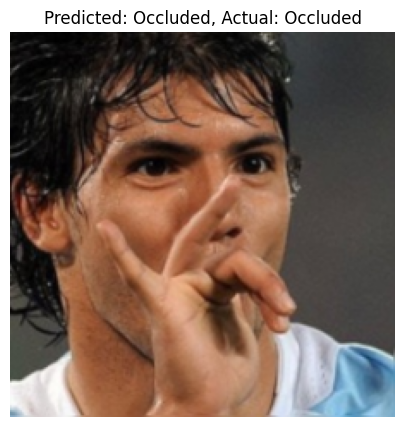

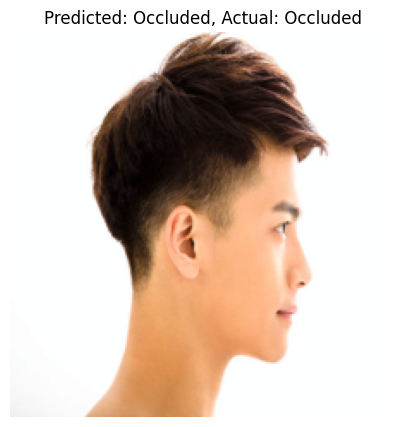

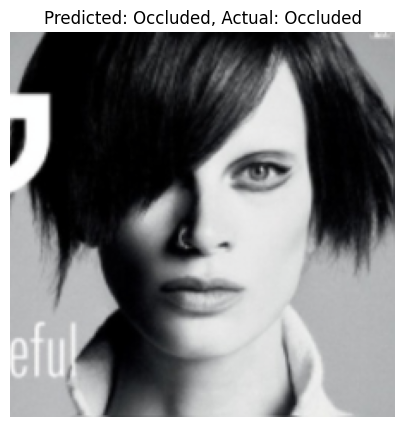

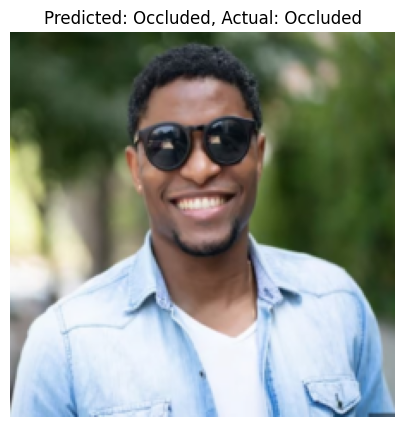

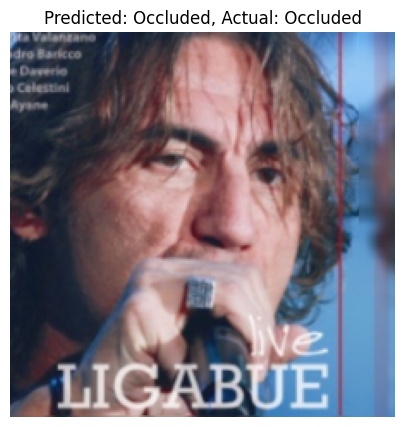

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Display predictions for 5 random images
for i, (images, labels) in enumerate(test_loader):
    if i == 5:  # Stop after 5 images
        break
    images, labels = images.to(device), labels.to(device)
    outputs = model_loaded(images)
    _, preds = torch.max(outputs, 1)

    # Convert images and labels to CPU for displaying
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(5,5))
    plt.axis('off')
    imshow(images[0], title=f'Predicted: {test_data.classes[preds[0]]}, Actual: {test_data.classes[labels[0]]}')
    plt.show()
